# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader



In [2]:
#https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2
from google.colab import drive
drive.mount('/content/gdrive')
# !ls /content/gdrive/MyDrive


if not os.path.exists("/content/gdrive/MyDrive/HW10"):
  os.mkdir("/content/gdrive/MyDrive/HW10", 0o666)

Mounted at /content/gdrive


# Download Dataset

In [3]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:15<00:00, 60.2MB/s]
100% 1.83G/1.83G [00:15<00:00, 124MB/s] 


In [ ]:
# !gdown --id 1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu

In [5]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [7]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [8]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4938),
 tensor(0.),
 tensor(1.))

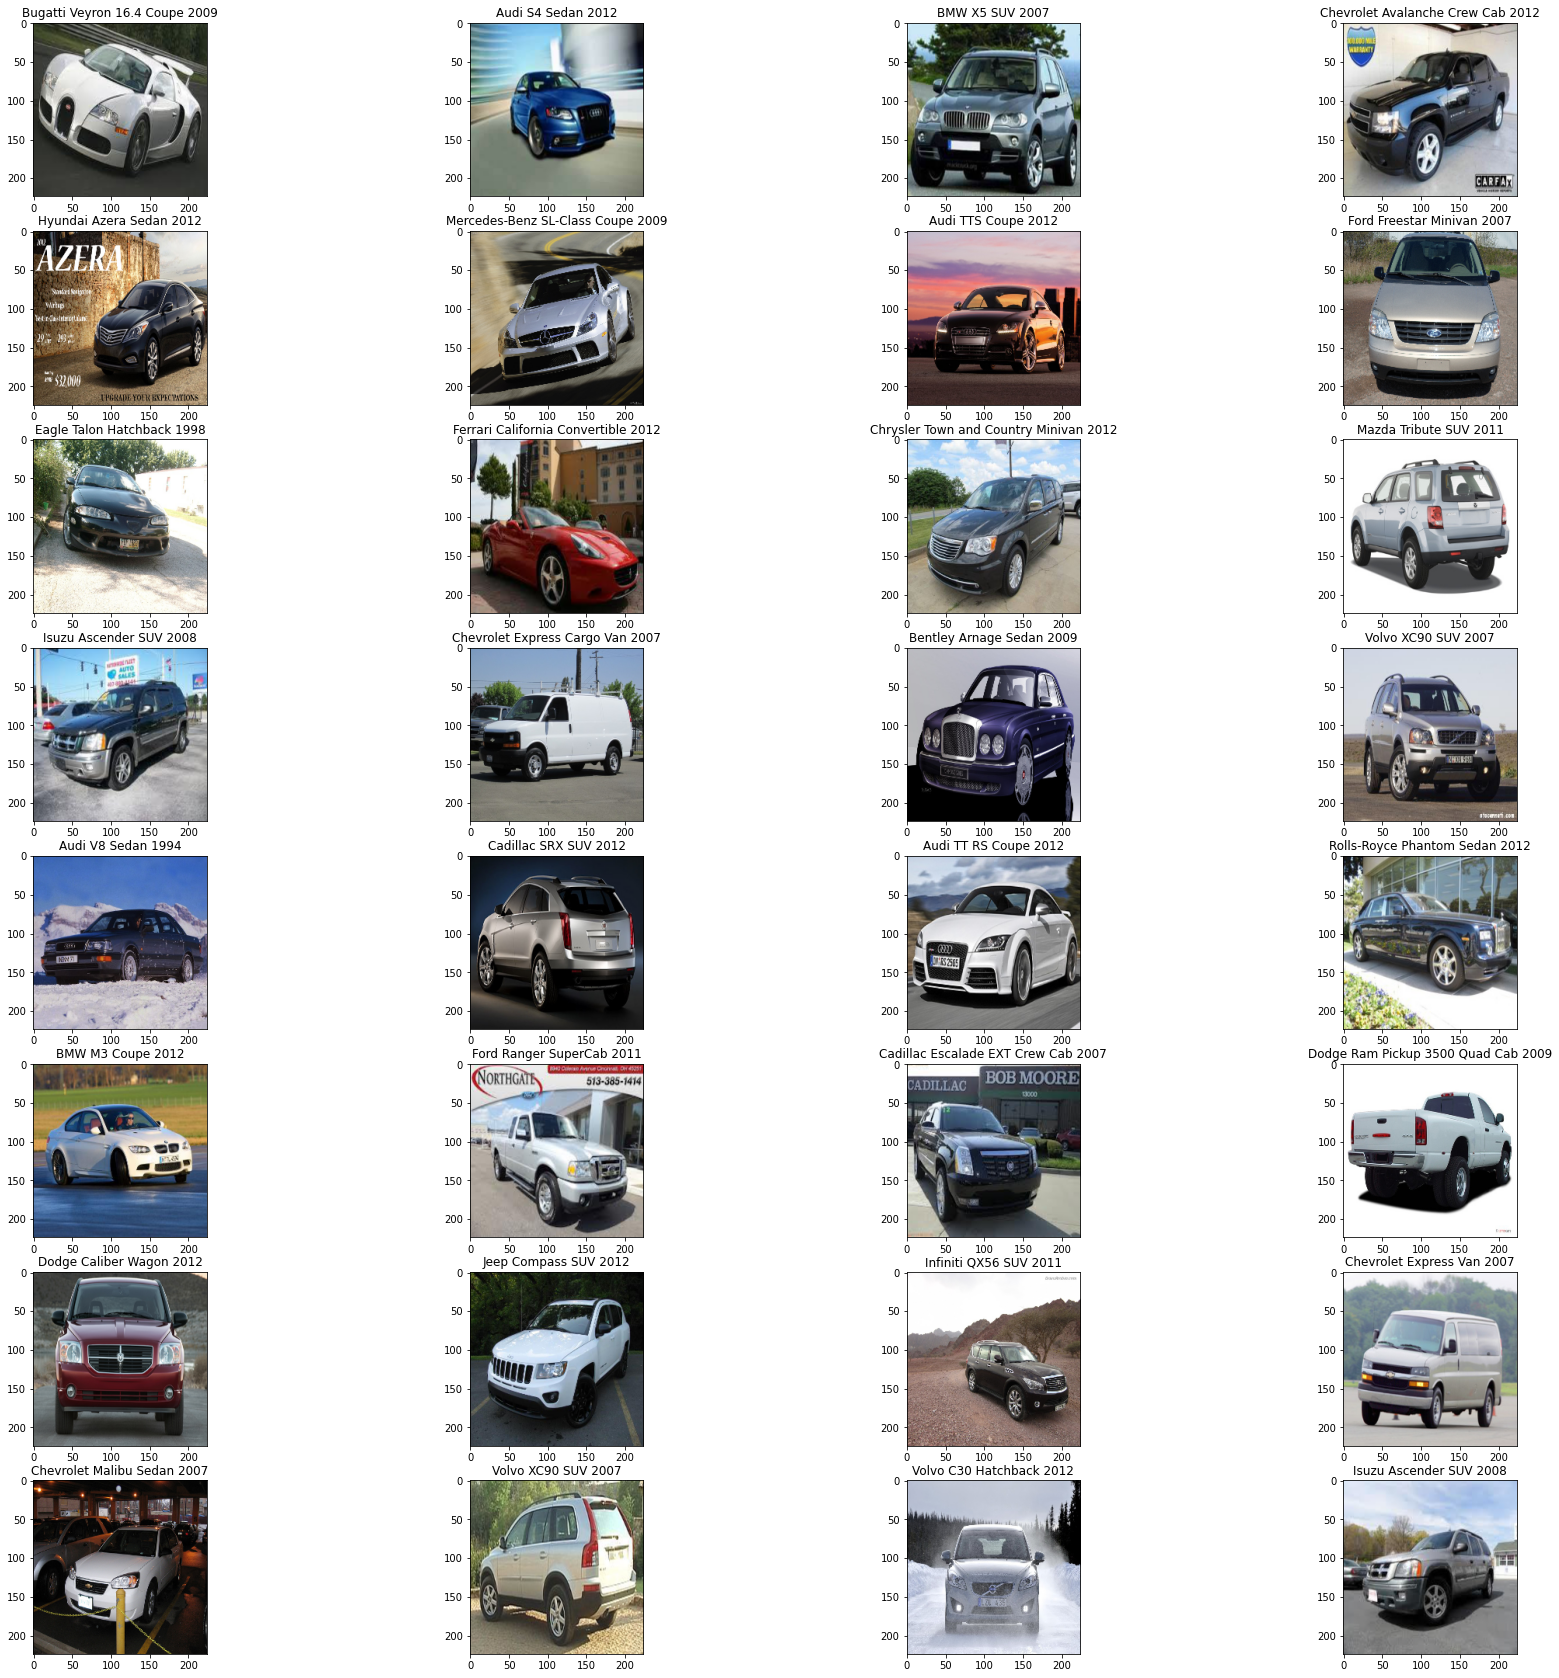

In [9]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [10]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)

#https://pytorch.org/docs/stable/generated/torch.load.html
def load_model_checkpoint_from_path(path, convert_to_device):
  return torch.load(path, map_location=convert_to_device)

def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['model_state_dict'])

def check_path_exists(path):
  if os.path.exists(path):
    return True
  return False

def plot_helper(history):
  with plt.style.context('ggplot'): #ggplot is good for visualization
    fig, ax = plt.subplots(1, 2, figsize=(10, 8))

    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].legend()

    ax[1].plot(history.history['val_accuracy'], label='val_acc')
    ax[1].plot(history.history['accuracy'], label='acc')
    ax[1].legend()

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = current_loss / dataset_sizes[phase]
            # epoch_acc = current_corrects.double() / dataset_sizes[phase]
            epoch_acc = 100/32*current_corrects/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [11]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])

        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

res_mod = models.resnet50(pretrained=True)
model = ResnetModel(res_mod, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

pytorch_total_params=  23909636
pytorch_total_trainable_params=  23909636


In [ ]:
model

ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)


# A) Train with random weights

In [57]:
class ANet(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ANet, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])

        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

In [58]:
A_PATH = "/content/gdrive/MyDrive/HW10/a_model.pt"

res_mod = models.resnet50(pretrained=False)
a_model = ANet(res_mod, num_classes=len(classes))


pytorch_total_params = sum(p.numel() for p in a_model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in a_model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

print("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

a_model = a_model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(a_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# we should check if we have checkpoint
if check_path_exists(A_PATH):
  checkpoint = load_model_checkpoint_from_path(A_PATH, device)
  base_model = load_checkpoint(checkpoint, a_model)
else:
  base_model = train_model(a_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)


pytorch_total_params=  23909636
pytorch_total_trainable_params=  23909636
cuda
=> loading checkpoint


In [ ]:
#save
A_PATH = "/content/gdrive/MyDrive/HW10/a_model.pt"
checkpoint = {
'model_state_dict': a_model.state_dict(),
'optimizer_state_dict': optimizer_ft.state_dict()
}
save_checkpoint(checkpoint, A_PATH)

=> saving checkpoint


# B) Feature Extractor

In [13]:
class BNet(nn.Module):
    def __init__(self, original_model, num_classes, in_features):
        super(BNet, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y


def set_parameter_requires_grad(model):
  for param in model.parameters():
      param.requires_grad = False

In [60]:
B_PATH = "/content/gdrive/MyDrive/HW10/b_model.pt"

res_mod = models.resnet50(pretrained=True)
features=res_mod.fc.in_features
set_parameter_requires_grad(res_mod)

b_model = BNet(res_mod, num_classes=len(classes), in_features=features)

pytorch_total_params = sum(p.numel() for p in b_model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in b_model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

print("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

b_model = b_model.to(device)
criterion = nn.CrossEntropyLoss() 

#we should update only trainable parameters
update_params = []
for _, param in b_model.named_parameters():
  if param.requires_grad == True:
    update_params.append(param)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(update_params, lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# we should check if we have checkpoint
if check_path_exists(B_PATH):
  checkpoint = load_model_checkpoint_from_path(B_PATH, device)
  base_model = load_checkpoint(checkpoint, b_model)
else:
  base_model = train_model(b_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)


#save

checkpoint = {
'model_state_dict': b_model.state_dict(),
'optimizer_state_dict': optimizer_ft.state_dict()
}
save_checkpoint(checkpoint, B_PATH)

pytorch_total_params=  24082948
pytorch_total_trainable_params=  574916
cuda
=> loading checkpoint
=> saving checkpoint


# C) SVM

In [17]:
class CNet(nn.Module):
    def __init__(self, original_model, num_classes, in_features):
        super(CNet, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])

        #since we have a classifier we should comment this
        # self.classifier = nn.Sequential(
        #     nn.Linear(in_features, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, num_classes)
        # )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        return y


res_mod = models.resnet50(pretrained=True)
features=res_mod.fc.in_features
set_parameter_requires_grad(res_mod)

c_model = CNet(res_mod, num_classes=len(classes), in_features=features)

pytorch_total_params = sum(p.numel() for p in c_model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in c_model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

print("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
c_model = c_model.to(device)

pytorch_total_params=  23508032
pytorch_total_trainable_params=  0
cuda


In [44]:
#https://scikit-learn.org/stable/modules/svm.html
#https://www.machinecurve.com/index.php/2020/05/03/creating-a-simple-binary-svm-classifier-with-python-and-scikit-learn/

from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
clf = svm.SVC(kernel='poly')

# epochss = 8

#train
# for epoch in range(epochss):
outputss = np.array([])
labelss = np.array([])
for inputs, labels in dataloaders['train']:
  inputs = inputs.to(device)
  labels = labels.to(device)

  #since it doesn't have any classifier we should forward manual
  outputs = c_model.forward(inputs)
  outputs = outputs.to(device)
  #can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
  #https://stackoverflow.com/questions/53467215/convert-pytorch-tensor-to-numpy-array-using-cuda
  # clf.fit(outputs.cpu().detach().numpy().reshape(-1, 1), labels.cpu().detach().numpy())
  #Found input variables with inconsistent numbers of samples: [32, 16]
  # print(outputs.cpu().detach().numpy())
  outputss = np.append(outputss, outputs.cpu().detach().numpy())
  labelss = np.append(labelss, labels.cpu().detach().numpy())
# predictions = clf.predict(X_test)

# # Generate confusion matrix
# matrix = plot_confusion_matrix(clf, X_test, y_test,
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')
# plt.title('Confusion matrix for our classifier')
# plt.show(matrix)
# plt.show()

In [57]:
print(outputss.shape)
outputss = outputss[:labelss.shape[0]]
print(outputss.shape)
print(labelss.shape)
clf.fit(outputss.reshape(-1, 1), labelss)


(8144,)
(8144,)
(8144,)


SVC(kernel='poly')

In [ ]:
for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  labels = labels.to(device)

  # outputs = c_model.forward(inputs)
  # outputs = outputs.to(device)
  # outputs = outputs.to(device)

  # print(inputs.shape)
  # nsamples, x, y, z = inputs.shape
  # inputs = inputs.reshape((nsamples, x*y*z))
  # predictions = clf.predict(outputs.cpu().detach().numpy())
  matrix = plot_confusion_matrix(clf, inputs.cpu().detach().numpy(), labels.cpu().detach().numpy(),
                                 cmap=plt.cm.Blues,
                                 normalize='true')
  
  print(matrix)


# D) Fine Tune

In [ ]:

def set_grad_to_true(model):
  for param in model.parameters():
    param.requires_grad = True

In [ ]:
C_PATH = "/content/gdrive/MyDrive/HW10/c_model.pt"

res_mod = models.resnet50(pretrained=True)
set_grad_to_true(res_mod)
features=res_mod.fc.in_features


c_model = BNet(res_mod, num_classes=len(classes), in_features=features)
load_checkpoint(torch.load("/content/gdrive/MyDrive/HW10/b_model.pt"), c_model)


pytorch_total_params = sum(p.numel() for p in c_model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in c_model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

print("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c_model = c_model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(c_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# we should check if we have checkpoint
if check_path_exists(C_PATH):
  checkpoint = load_model_checkpoint_from_path(C_PATH, device)
  base_model = load_checkpoint(checkpoint, c_model)
else:
  base_model = train_model(c_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)


#save

checkpoint = {
'model_state_dict': c_model.state_dict(),
'optimizer_state_dict': optimizer_ft.state_dict()
}
save_checkpoint(checkpoint, C_PATH)



=> loading checkpoint
pytorch_total_params=  24082948
pytorch_total_trainable_params=  24082948
cuda
Epoch 0/4
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 132.5876 Acc: 7.5980
Iterating through data...
val Loss: 158.6763 Acc: 6.5600

Epoch 1/4
----------
Iterating through data...
train Loss: 103.4721 Acc: 17.4142
Iterating through data...
val Loss: 118.7698 Acc: 12.3388

Epoch 2/4
----------
Iterating through data...
train Loss: 86.9601 Acc: 25.2696
Iterating through data...
val Loss: 101.8825 Acc: 18.7500

Epoch 3/4
----------
Iterating through data...
train Loss: 73.5936 Acc: 33.4314
Iterating through data...
val Loss: 107.1364 Acc: 18.2416

Epoch 4/4
----------
Iterating through data...
train Loss: 62.1942 Acc: 41.6422
Iterating through data...
val Loss: 97.5177 Acc: 24.2188

Training complete in 29m 14s
Best val Acc: 24.218752
=> saving checkpoint


# E) Output layers

utils for handling hooks and output and also printing

In [61]:
#https://medium.com/the-owl/using-forward-hooks-to-extract-intermediate-layer-outputs-from-a-pre-trained-model-in-pytorch-1ec17af78712

test_loader=iter(test_data_loader)
images, labels = test_loader.next()
image, label = images[0], labels[0]
print(image.shape)
image = image.to(device)
image = image.reshape((1, 3, 224, 224))
print(image.shape)


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [62]:
before_outputs = []
hooks_for_handle_before = []

def hook_before(module, input, output):
  before_outputs.append(output)


for layer in a_model.modules():
  hook = layer.register_forward_hook(hook_before)
  hooks_for_handle_before.append(hook)

output = a_model(image)

#https://discuss.pytorch.org/t/how-to-count-the-number-of-zero-weights-in-a-pytorch-model/13549

number_zeros_in_before = []
for layer in before_outputs:
  out = torch.sum(layer == 0)
  number_zeros_in_before.append( (float(out) / len(torch.flatten(layer))) )


In [63]:
after_outputs = []
hooks_for_handle_after = []

def hook_after(module, input, output):
  after_outputs.append(output)


for layer in b_model.modules():
  hook = layer.register_forward_hook(hook_after)
  hooks_for_handle_after.append(hook)

output = b_model(image)

#https://discuss.pytorch.org/t/how-to-count-the-number-of-zero-weights-in-a-pytorch-model/13549

number_zeros_in_after = []
for layer in after_outputs:
  out = torch.sum(layer == 0)
  number_zeros_in_after.append((float(out) / len(torch.flatten(layer))))

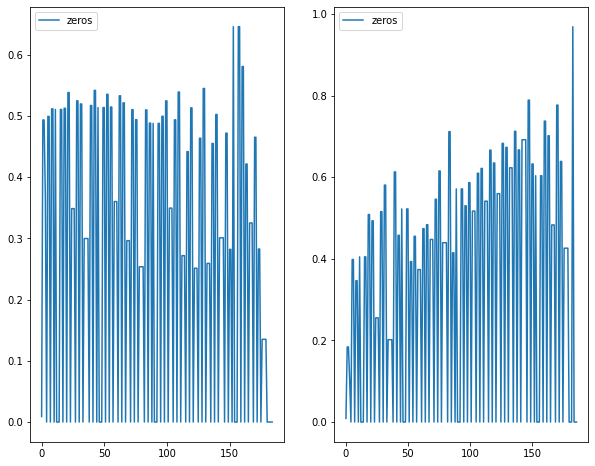

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(number_zeros_in_before, label='zeros')
ax[0].legend()

ax[1].plot(number_zeros_in_after, label='zeros')
ax[1].legend()

plt.show()